In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load the JSON file
with open("FVC2006.json", "r") as file:
    data = json.load(file)

# Convert MongoDB ObjectId fields
for record in data:
    if '_id' in record and '$oid' in record['_id']:
        record['_id'] = record['_id']['$oid']

# Convert to DataFrame
df = pd.DataFrame(data)

# Filter the DataFrame to keep only records where sub_db is 'DB2_A'
df_filtered = df[df['sub_db'] == 'DB2_A']

# print(df_filtered)

In [3]:
person_id = df_filtered['id']

pose_points = df_filtered['sp_pose'].apply(lambda x: (x['core'][0], x['core'][1]))

minutia_points = [list(map(lambda sublist: (sublist[0], sublist[1]), sublist)) for sublist in df_filtered['mv_25']]

In [4]:
data_df = pd.DataFrame({
    'person_id': person_id,
    'pose_point': pose_points,
    'minutiae_points': minutia_points
})

In [5]:
data_df['sort_key'] = data_df['person_id'].str.extract(r'(\d+)_')[0].astype(int)
data_df = data_df.sort_values('sort_key').drop(columns=['sort_key']).reset_index(drop=True)

In [6]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[1])**2 + (point1[1] - point2[0])**2)

def remove_minutiae_points(pose_point, minutiae_points):
    new_minutiae_points = []
    # new_minutiae_points.append((pose_point[1],pose_point[0]))
    for point in minutiae_points:
        distance_from_pose = euclidean_distance(pose_point, point)
        if(distance_from_pose <= 150):
            new_minutiae_points.append(point)

    return new_minutiae_points

data_df['minutiae_points_near_pose_point'] = data_df.apply(lambda row : remove_minutiae_points(row['pose_point'],row['minutiae_points']), axis= 1)

In [7]:
data_df.head()

,person_id,pose_point,minutiae_points,minutiae_points_near_pose_point
0,1_6,"(214, 301)","[(57, 180), (83, 115), (218, 169), (221, 110),...","[(218, 169), (221, 110), (236, 306), (172, 211..."
1,1_3,"(204, 292)","[(200, 232), (83, 199), (83, 208), (103, 160),...","[(200, 232), (217, 179), (249, 111), (249, 238..."
2,1_5,"(219, 281)","[(187, 186), (88, 165), (100, 195), (102, 189)...","[(187, 186), (187, 243), (196, 181), (201, 192..."
3,1_7,"(212, 306)","[(95, 163), (186, 105), (211, 67), (220, 114),...","[(220, 114), (233, 208), (161, 221), (178, 274..."
4,1_11,"(176, 342)","[(117, 258), (194, 173), (244, 76), (347, 54),...","[(194, 173), (244, 76), (347, 54), (478, 203),..."


In [8]:
def construct_minutiae_graph(minutiae_points):

    minutiae_points = np.array(minutiae_points)
    num_points = len(minutiae_points)
    adjacency_matrix = np.zeros((num_points, num_points), dtype=int)

    # Calculate distances between all pairs of points
    distances = np.zeros((num_points, num_points))
    for i in range(1,num_points):
        for j in range(1,num_points):
            if i != j:
                distances[i][j] = euclidean_distance(minutiae_points[i], minutiae_points[j])
            else:
                distances[i][j] = 0

    for i in range(1,num_points):
        adjacency_matrix[0][i] = euclidean_distance(minutiae_points[0], minutiae_points[i])

    # Find k nearest neighbors for each point and update the adjacency matrix
    for i in range(1,num_points):
        # Get indices of the k nearest points
        nearest_indices = np.argsort(distances[i])[:3]  
        for idx in nearest_indices:
            # if closest point of x is point y then it is not necessary that x is closest point of y
            adjacency_matrix[i][idx] = distances[i][idx]
            adjacency_matrix[i][idx] = distances[idx][i]

    return adjacency_matrix

data_df['minutia_graph'] = data_df.apply(lambda row: construct_minutiae_graph(row['minutiae_points_near_pose_point']),axis=1)

In [9]:
# for i in data_df['minutia_graph'][1]:
#     print(i)

In [10]:
filtered_df = data_df[data_df['person_id'] == '40_11']

minutia_points = filtered_df['minutiae_points'].iloc[0]
pose_minutia_points = filtered_df['minutiae_points_near_pose_point'].iloc[0]
adjacency_matrix = filtered_df['minutia_graph'].iloc[0]

cord = filtered_df['pose_point'].iloc[0]
y_cord = cord[0]
x_cord = cord[1]

# print(minutia_points)
# print(x_cord)
# print(y_cord)
# for i in adjacency_matrix:
#     print(i)

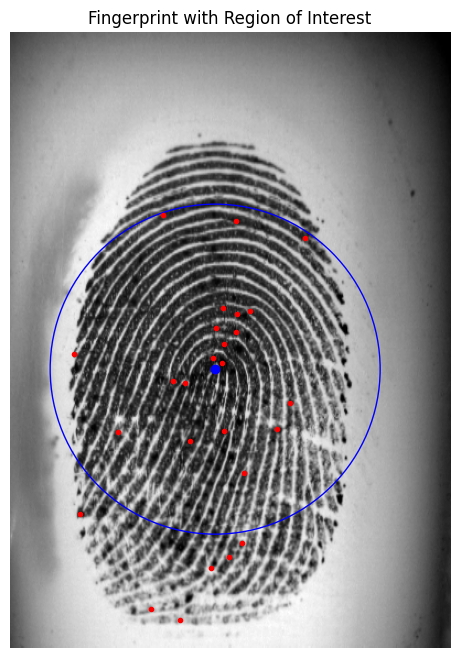

In [11]:
# Load the fingerprint image
image_path = 'test_subject_40/40_11.bmp'
fingerprint_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Get image dimensions
height, width = fingerprint_image.shape

# Plot the fingerprint image
plt.figure(figsize=(8, 8))
plt.imshow(fingerprint_image, cmap='gray')

# Overlay the adjusted minutia points as pixels
for (x, y) in minutia_points:
    plt.plot(y, x, 'ro', markersize = 3)  # 'ro' means red color and circle marker, markersize sets the size of the points

# Get the current axes and add the circle patch
ax = plt.gca()
circle = plt.Circle((y_cord, x_cord), 150, edgecolor='b', facecolor='none')
ax.add_patch(circle)
ax.plot(y_cord, x_cord, 'bo')

# Show the plot
plt.title('Fingerprint with Region of Interest')
plt.axis('off')  # Hide axes
plt.gca() # Invert y axis to match image coordinate system
plt.show()

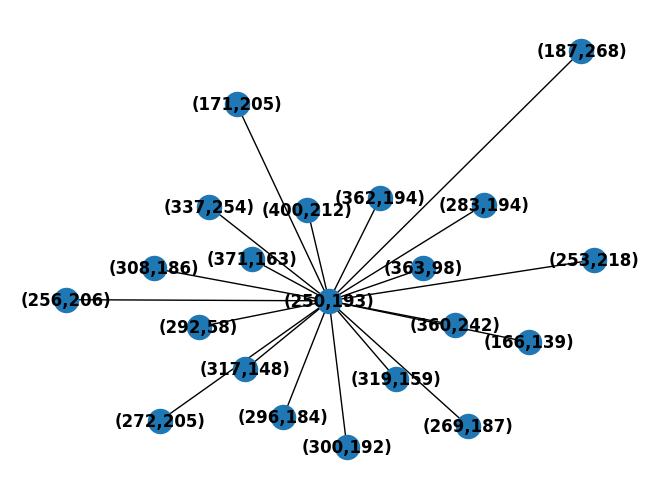

In [12]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Create a new graph for edges only in the first row
G_first_row = nx.Graph()

# Add nodes from the original graph
G_first_row.add_nodes_from(G.nodes)

# Add edges from the first row of the adjacency matrix
for i, weight in enumerate(adjacency_matrix[0]):
    if weight > 0:  # Assuming 0 means no edge
        G_first_row.add_edge(0, i, weight=weight)

# Create a mapping from node index to minutia points
label_mapping = {i: f"({x},{y})" for i, (x, y) in enumerate(pose_minutia_points)}

# Draw the graph with the minutia points as node names
pos = nx.spring_layout(G_first_row, seed=42)  # seed=42 for reproducibility
nx.draw(G_first_row, with_labels=True, pos=pos, labels=label_mapping, font_weight='bold')
plt.show()

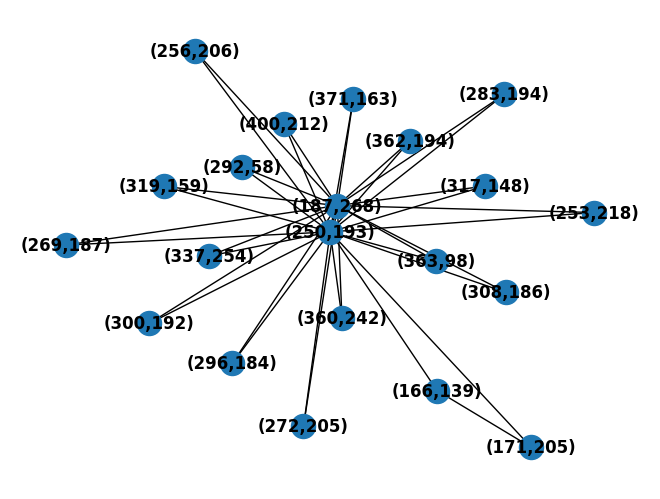

In [13]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Create a mapping from node index to minutia points
label_mapping = {i: f"({x},{y})" for i, (x, y) in enumerate(pose_minutia_points)}

# Draw the graph with the minutia points as node names
pos = nx.spring_layout(G)  # seed=42 for reproducibility
nx.draw(G, with_labels=True,pos=pos ,labels=label_mapping, font_weight='bold')
plt.show()

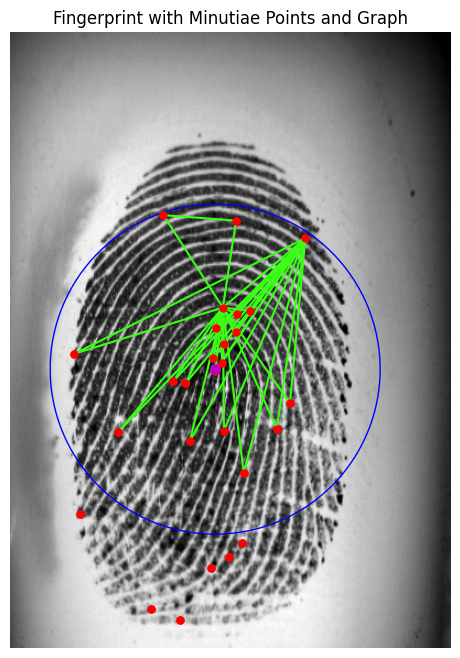

In [14]:
# Load the fingerprint image
image_path = 'test_subject_40/40_11.bmp'
fingerprint_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Get image dimensions
height, width = fingerprint_image.shape

# Plot the fingerprint image
plt.figure(figsize=(8, 8))
plt.imshow(fingerprint_image, cmap='gray')

# Overlay the adjusted minutia points as pixels
for (x, y) in minutia_points:
    plt.plot(y, x, 'ro', markersize=5)  # 'ro' means red color and circle marker, markersize sets the size of the points

# Draw the graph on top of the fingerprint image
# Extract the x and y coordinates of the minutia points
pos = {i: (y, x) for i, (x, y) in enumerate(pose_minutia_points)}

# Draw edges
for edge in G.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, '#39FF14')  # 'b-' means blue color and solid line

# # Draw edges
# for edge in G_first_row.edges():
#     x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
#     y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
#     plt.plot(x_coords, y_coords, 'b-')  # 'b-' means blue color and solid line

# Draw nodes on top again to make sure they are visible
for (x, y) in minutia_points:
    plt.plot(y, x, 'ro', markersize=5)

ax = plt.gca()
circle = plt.Circle((y_cord, x_cord), 150, edgecolor='b', facecolor='none')
ax.add_patch(circle)
ax.plot(y_cord, x_cord, 'mo', markersize=7)  # cyan

# Show the plot
plt.title('Fingerprint with Minutiae Points and Graph')
plt.axis('off')  # Hide axes
plt.gca() # Invert y axis to match image coordinate system
plt.show()

In [15]:
# test_condition = data_df['person_id'].str.endswith(('_11', '_12'))

# # Create the test DataFrame
# test_df = data_df[test_condition]

# # Create the train DataFrame
# train_df = data_df[~test_condition]

# print("Test DataFrame:", test_df.shape)
# print("Train DataFrame:", train_df.shape)

In [16]:
# # Save test_df to a CSV file
# test_df.to_csv('align_gcn_outputs/DB2A_test_df.csv', index=False)

# # Save train_df to a CSV file
# train_df.to_csv('align_gcn_outputs/DB2A_train_df.csv', index=False)

In [17]:
train_df = data_df[data_df['person_id'].str.startswith(('40_','41_','42_'))]
test_condition = train_df['person_id'].str.endswith(('_11', '_12'))
test_df = train_df[test_condition]
train_df = train_df[~test_condition]
print("Test DataFrame:", test_df.shape)
print("Train DataFrame:", train_df.shape)
train_df

Test DataFrame: (6, 5)
Train DataFrame: (30, 5)


,person_id,pose_point,minutiae_points,minutiae_points_near_pose_point,minutia_graph
469,40_5,"(203, 337)","[(351, 167), (383, 211), (386, 169), (409, 231...","[(351, 167), (383, 211), (386, 169), (409, 231...","[[0, 257, 284, 270, 330, 144, 196, 203, 182, 2..."
471,40_7,"(208, 326)","[(104, 197), (119, 235), (129, 359), (139, 253...","[(222, 296), (251, 305), (307, 76), (366, 78),...","[[0, 94, 146, 160, 115, 112, 110, 33, 8, 23, 2..."
472,40_4,"(197, 281)","[(126, 279), (149, 213), (223, 83), (224, 231)...","[(149, 213), (223, 83), (224, 231), (280, 198)...","[[0, 66, 82, 83, 113, 141, 177, 57, 74, 72, 61..."
473,40_3,"(216, 289)","[(119, 138), (128, 264), (141, 121), (148, 159...","[(158, 230), (208, 111), (236, 249), (291, 214...","[[0, 51, 91, 82, 75, 100, 135, 174, 72, 75, 71..."
474,40_10,"(196, 290)","[(120, 244), (126, 138), (140, 261), (163, 206...","[(163, 206), (170, 282), (223, 176), (234, 229...","[[0, 124, 21, 71, 135, 146, 191, 225, 19, 50, ..."
475,40_2,"(195, 251)","[(45, 78), (84, 207), (100, 231), (120, 211), ...","[(120, 211), (307, 206), (198, 207), (212, 195...","[[0, 128, 87, 75, 97, 76, 74, 60, 70, 160, 89,..."
476,40_1,"(198, 302)","[(128, 182), (136, 247), (144, 161), (165, 141...","[(165, 141), (196, 117), (230, 316), (233, 99)...","[[0, 73, 175, 113, 157, 163, 172, 202, 209, 22..."
477,40_8,"(202, 301)","[(133, 151), (180, 220), (318, 363), (407, 174...","[(180, 220), (407, 174), (442, 184), (248, 211...","[[0, 187, 222, 41, 47, 67, 59, 58, 114, 71, 74..."
478,40_6,"(197, 258)","[(74, 161), (95, 137), (113, 269), (129, 211),...","[(129, 211), (196, 82), (258, 197), (270, 169)...","[[0, 49, 82, 71, 90, 131, 83, 72, 83, 68, 89, ..."
479,40_9,"(249, 316)","[(132, 151), (179, 186), (242, 140), (255, 332...","[(242, 140), (255, 332), (282, 335), (368, 220...","[[0, 146, 169, 229, 229, 249, 44, 123, 124, 12..."


In [18]:
from node2vec import Node2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Step 1: Convert adjacency matrices to NetworkX graphs
def adjacency_matrix_to_graphs(df):
    graphs = []
    for adj_matrix in df['minutia_graph']:
        G = nx.from_numpy_array(adj_matrix)
        graphs.append(G)
    return graphs

graphs = adjacency_matrix_to_graphs(train_df)

In [20]:
dimensions = 512
walk_length = 50
num_walks = 200

node_embeddings = []
for G in graphs:
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = {int(node): model.wv[str(node)] for node in G.nodes()}
    node_embeddings.append(embeddings)

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 103.38it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:01<00:00, 26.85it/s]


In [21]:
data_list = []
for i, G in enumerate(graphs):
    embedding = node_embeddings[i]
    x = torch.tensor([embedding[node] for node in G.nodes()], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
    person_id = train_df.iloc[i]['person_id']
    data = Data(x=x, edge_index=edge_index, person_id=person_id)
    data_list.append(data)

/tmp/ipykernel_63319/2177138131.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  x = torch.tensor([embedding[node] for node in G.nodes()], dtype=torch.float)


In [22]:
def collate(batch):
    # Group data by person_id
    grouped_data = {}
    for data in batch:
        if data.person_id.item() not in grouped_data:
            grouped_data[data.person_id.item()] = []
        grouped_data[data.person_id.item()].append(data)
    
    # Create batches of 10 graphs per person
    final_batch = []
    for person_id, data_list in grouped_data.items():
        for i in range(0, len(data_list), 10):
            final_batch.extend(data_list[i:i+10])
    
    return Batch.from_data_list(final_batch)

loader = DataLoader(data_list, batch_size=10, shuffle=False, collate_fn=collate)

/home/user/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = dimensions
hidden_dim = 128
output_dim = 512
model = GCN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [25]:
def train():
    model.train()
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.x)
        loss.backward()
        optimizer.step()

In [26]:
def get_graph_embeddings(loader):
    model.eval()
    graph_embeddings = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            graph_embedding = global_mean_pool(out, batch.batch)
            graph_embeddings.append(graph_embedding.cpu().numpy())
    return np.concatenate(graph_embeddings, axis=0)

graph_embeddings = get_graph_embeddings(loader)

In [27]:
for i in graph_embeddings:
    print(i)

[-0.02389091 -0.00340467 -0.05315057 -0.0292717   0.00396422 -0.0077803
 -0.0363508   0.00107152  0.03347256 -0.02017368 -0.00248288  0.02509742
 -0.06243778  0.02142389  0.02622383 -0.01986947 -0.05658499 -0.00915007
  0.01124023 -0.00934446 -0.06185585  0.03620441  0.01058856 -0.04829101
 -0.00040789  0.04058461  0.01658831 -0.04874559  0.01876991 -0.04344315
  0.02454554  0.00116419  0.02436101 -0.0559257   0.03129973  0.0228376
 -0.00927665 -0.01319135 -0.00032204  0.0104504   0.00661794 -0.00684676
  0.04331579  0.00859761  0.0303703  -0.03012664  0.00017843 -0.00193436
  0.02011463 -0.0543349  -0.00690945  0.0048577   0.02238243 -0.00020764
 -0.02827093 -0.02418628  0.01512034 -0.01412697  0.05958206 -0.00581335
 -0.02975641 -0.04786057 -0.02248495  0.01737657 -0.00197286 -0.0048341
  0.01003491  0.00959628 -0.01785454 -0.0265139  -0.0222491  -0.02755116
 -0.01484072 -0.00532476  0.00376767 -0.03933045  0.0410284  -0.01668386
 -0.03634988  0.03965789 -0.00770903  0.01988724  0.05

In [28]:
reshaped_embedding = graph_embeddings.reshape(3, 10, 512)

In [29]:
def align(array):
    array_mean = np.mean(array)
    array_std = np.std(array)
    normalized_array = (array - array_mean) / array_std
    return normalized_array

def align_embedding(reshaped_embedding):
    aligned_arrays = []
    
    for array in reshaped_embedding:
        align_array = align(array)
        aligned_arrays.append(align_array)
    
    return np.array(aligned_arrays)

normalized_embedding = align_embedding(reshaped_embedding)
normalized_embedding.shape

(3, 10, 512)

In [30]:
from scipy.optimize import minimize
import numpy as np

# Objective function for optimization
def objective(x, target, reference):
    transformed_array = x[0] * reference + x[1]
    return np.mean((target - transformed_array) ** 2)

# Function to transform embeddings to align with the reference embedding
def transform_embeddings(embeddings, retain_percentage, initial_guess=[1, 0]):
    transformed_embeddings = np.zeros_like(embeddings)
    reference_embedding = embeddings[0]

    for i in range(1, embeddings.shape[0]):
        target_embedding = embeddings[i]
        result = minimize(objective, initial_guess, args=(target_embedding, reference_embedding))
        optimal_scale, optimal_shift = result.x
        transformed_part = optimal_scale * reference_embedding + optimal_shift
        transformed_embeddings[i] = retain_percentage * target_embedding + (1 - retain_percentage) * transformed_part

    transformed_embeddings[0] = reference_embedding
    return transformed_embeddings

# Function to apply the transformation to each element of normalized_embedding
def transform_all_embeddings(normalized_embedding, retain_percentage):
    transformed_all = np.zeros_like(normalized_embedding)
    
    for i in range(normalized_embedding.shape[0]):
        transformed_all[i] = transform_embeddings(normalized_embedding[i], retain_percentage)
    
    return transformed_all

# Example usage:
retain_percentage = 0.20  # Specify the percentage of originality to retain
transformed_embedding = transform_all_embeddings(normalized_embedding, retain_percentage)

In [31]:
new_embeddings = transformed_embedding.reshape(30, 512)

In [32]:
similarity_matrix = cosine_similarity(new_embeddings)
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

In [33]:
for i in range(len(normalized_similarity_matrix)):
    for j in range(len(normalized_similarity_matrix)):
        print(f"Normalized Similarity between Graph {i+1} and Graph {j+1}: {normalized_similarity_matrix[i, j]:.4f}")

Normalized Similarity between Graph 1 and Graph 1: 1.0000
Normalized Similarity between Graph 1 and Graph 2: 0.9733
Normalized Similarity between Graph 1 and Graph 3: 0.9616
Normalized Similarity between Graph 1 and Graph 4: 0.9701
Normalized Similarity between Graph 1 and Graph 5: 0.9563
Normalized Similarity between Graph 1 and Graph 6: 0.9808
Normalized Similarity between Graph 1 and Graph 7: 0.9222
Normalized Similarity between Graph 1 and Graph 8: 0.9044
Normalized Similarity between Graph 1 and Graph 9: 0.9782
Normalized Similarity between Graph 1 and Graph 10: 0.9509
Normalized Similarity between Graph 1 and Graph 11: 0.0259
Normalized Similarity between Graph 1 and Graph 12: 0.0000
Normalized Similarity between Graph 1 and Graph 13: 0.0115
Normalized Similarity between Graph 1 and Graph 14: 0.0438
Normalized Similarity between Graph 1 and Graph 15: 0.0000
Normalized Similarity between Graph 1 and Graph 16: 0.0000
Normalized Similarity between Graph 1 and Graph 17: 0.0181
Normal

In [34]:
keys = pd.DataFrame({'graph_embeddings': [embedding for embedding in new_embeddings]})
print(keys)

                                     graph_embeddings
0   [-0.7832478, -0.072002865, -1.7990899, -0.9700...
1   [-0.6514122, -0.061164934, -1.6925968, -0.8276...
2   [-0.5178166, -0.054537173, -1.713394, -0.91389...
3   [-0.6480149, -0.14164324, -1.6580932, -0.86901...
4   [-0.49380934, -0.18864027, -1.8924706, -1.1225...
5   [-0.44809932, 0.050275892, -1.7381712, -1.0657...
6   [-0.6516869, -0.05921687, -1.8659083, -1.02111...
7   [-0.3659773, -0.07087362, -1.8781291, -0.90968...
8   [-0.49761254, -0.14063337, -1.6839947, -0.8870...
9   [-0.5149509, -0.03316111, -1.8724953, -1.30012...
10  [-0.1474133, -0.17275967, -1.5290971, -1.13954...
11  [0.0028388351, -0.26785898, -1.5615492, -1.255...
12  [-0.11520078, -0.1921517, -1.7152935, -1.10594...
13  [-0.2547045, -0.28217825, -1.617353, -1.011234...
14  [0.070664145, -0.26437807, -1.6991127, -1.0844...
15  [0.0610734, -0.3111602, -1.5127697, -1.1884896...
16  [0.00990551, -0.3143903, -1.4701452, -1.345105...
17  [-0.0715311, -0.24331364

# KEY GENERATION METHOD 1

In [35]:
def binary_key_generator(fv1):
    
    addition_value_vector = np.zeros(256, dtype=int)
    for i in range(256):
        j = 511-i
        addition_value_vector[i] = int(fv1[i]+fv1[j])
        #print(addition_value_vector[i])

    #print(addition_value_vector) 

    final_fv1 = np.zeros(128, dtype=int)
    for i in range(128):
        j = 255-i
        final_fv1[i] = (addition_value_vector[i] ^ addition_value_vector[j]) % 2
        #print(final_fv1[i])

    #print(final_fv1) 
    return final_fv1

keys['binary_key'] = keys['graph_embeddings'].apply(binary_key_generator)

In [36]:
for x in keys['binary_key'] :
    print(x)

[0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1
 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1]
[1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1
 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1
 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1]
[1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0
 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1]
[0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1
 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 

In [37]:
def hamming_distance_numpy(x, y):
    # Ensure both strings are of the same length
    assert len(x) == len(y), "Binary strings must be of the same length"
    return np.sum(np.array(x) != np.array(y))

In [38]:
num_rows = len(keys['binary_key'])
num_cols = num_rows
hamming_distance_matrix = np.zeros((num_rows, num_cols), dtype=int)

for i in range(num_rows):
    x = keys['binary_key'].iloc[i]
    for j in range(num_cols):
        y = keys['binary_key'].iloc[j]
        hamming_distance_matrix[i, j] = hamming_distance_numpy(x, y)

In [39]:
for x in hamming_distance_matrix:
    print(x)

[ 0 24 22 23 23 17 34 35 24 21 63 63 64 55 57 61 68 64 67 63 64 61 64 59
 57 63 56 62 59 64]
[24  0 26 19 31 15 30 41 24 23 71 59 64 65 57 65 72 64 67 61 62 61 56 59
 61 57 50 58 57 52]
[22 26  0 29 21 17 30 41 32 25 63 57 56 55 51 53 62 54 57 55 58 57 60 55
 55 59 52 62 55 62]
[23 19 29  0 26 18 29 36 23 24 66 68 63 62 58 70 69 69 70 68 61 60 55 56
 58 54 51 57 56 57]
[23 31 21 26  0 26 29 38 29 24 62 60 59 56 58 56 63 59 64 58 55 60 57 60
 52 56 49 57 52 59]
[17 15 17 18 26  0 27 36 23 20 66 64 63 62 58 66 71 63 64 64 61 58 57 60
 58 58 49 53 54 59]
[34 30 30 29 29 27  0 35 34 25 59 59 58 57 53 59 60 58 61 61 58 61 48 59
 55 53 52 58 51 52]
[35 41 41 36 38 36 35  0 35 36 64 68 69 58 64 64 61 63 64 70 63 62 53 58
 58 58 61 53 60 63]
[24 24 32 23 29 23 34 35  0 25 63 63 62 59 57 63 64 64 63 63 58 59 56 61
 53 55 54 52 53 58]
[21 23 25 24 24 20 25 36 25  0 68 64 65 64 56 64 71 69 68 66 59 62 59 62
 56 56 59 57 56 65]
[63 71 63 66 62 66 59 64 63 68  0 38 43 30 34 34 27 27 30 34 65 66 67 

In [40]:
import os

# Directory to save the model and embeddings
output_dir = "align_gcn_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the GCN model
model_path = os.path.join(output_dir, "align_gcn_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to align_gcn_outputs/align_gcn_model.pth


In [41]:
# Extract Graph-Level Embeddings
def get_graph_embeddings(loader):
    model.eval()
    graph_embeddings = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            graph_embedding = global_mean_pool(out, torch.tensor([0]).to(device))  # Assuming one graph per batch
            graph_embeddings.append(graph_embedding.cpu().numpy())
    return np.concatenate(graph_embeddings, axis=0)

# Get embeddings and save them
graph_embeddings = get_graph_embeddings(loader)
np.save(os.path.join(output_dir, "graph_embeddings.npy"), graph_embeddings)
print("Graph embeddings saved.")

Graph embeddings saved.


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def evaluate_embedding_similarity_percentage(embeddings):
    # Compute cosine similarity matrix for graph embeddings
    similarity_matrix = cosine_similarity(embeddings)
    
    # Normalize the similarity matrix to 0–1 range
    scaler = MinMaxScaler()
    normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)
    
    # Convert normalized similarities to percentage
    similarity_percentage_matrix = normalized_similarity_matrix * 100
    
    # Print similarity in percentage for each pair of embeddings
    print("Cosine Similarity between Graph Embeddings (in percentage):")
    for i in range(len(similarity_percentage_matrix)):
        for j in range(len(similarity_percentage_matrix)):
            print(f"Similarity between Graph {i + 1} and Graph {j + 1}: {similarity_percentage_matrix[i, j]:.2f}%")
    
    return similarity_percentage_matrix

# Call the function with graph embeddings
similarity_percentage_matrix = evaluate_embedding_similarity_percentage(new_embeddings)

Cosine Similarity between Graph Embeddings (in percentage):
Similarity between Graph 1 and Graph 1: 100.00%
Similarity between Graph 1 and Graph 2: 97.33%
Similarity between Graph 1 and Graph 3: 96.16%
Similarity between Graph 1 and Graph 4: 97.01%
Similarity between Graph 1 and Graph 5: 95.63%
Similarity between Graph 1 and Graph 6: 98.08%
Similarity between Graph 1 and Graph 7: 92.22%
Similarity between Graph 1 and Graph 8: 90.44%
Similarity between Graph 1 and Graph 9: 97.82%
Similarity between Graph 1 and Graph 10: 95.09%
Similarity between Graph 1 and Graph 11: 2.59%
Similarity between Graph 1 and Graph 12: 0.00%
Similarity between Graph 1 and Graph 13: 1.15%
Similarity between Graph 1 and Graph 14: 4.38%
Similarity between Graph 1 and Graph 15: 0.00%
Similarity between Graph 1 and Graph 16: 0.00%
Similarity between Graph 1 and Graph 17: 1.81%
Similarity between Graph 1 and Graph 18: 5.44%
Similarity between Graph 1 and Graph 19: 1.54%
Similarity between Graph 1 and Graph 20: 0.00

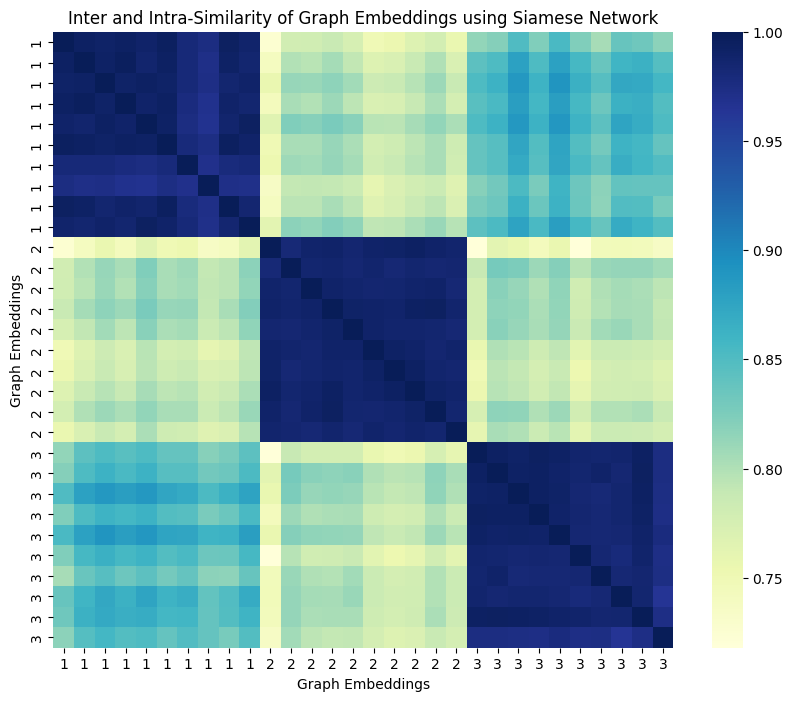

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(new_embeddings)

# Create custom labels for the x and y axes
group_labels = np.repeat([1, 2, 3], 10)  # Modify according to the number of groups and size

# Create a heatmap to visualize the similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='YlGnBu', cbar=True, xticklabels=group_labels, yticklabels=group_labels)
plt.title('Inter and Intra-Similarity of Graph Embeddings using Siamese Network')
plt.xlabel('Graph Embeddings')
plt.ylabel('Graph Embeddings')
plt.show()

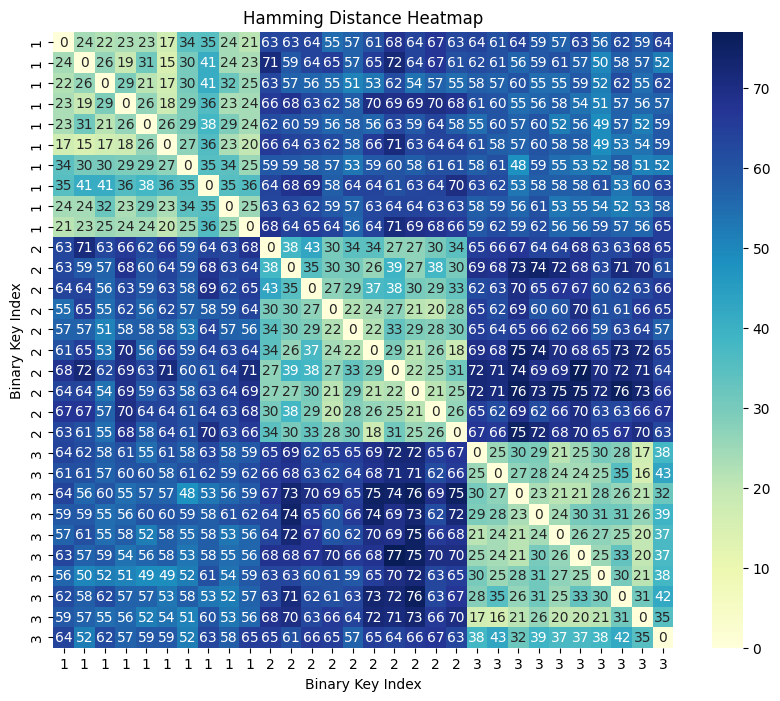

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(hamming_distance_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True, xticklabels=group_labels, yticklabels=group_labels)
plt.title('Hamming Distance Heatmap')
plt.xlabel('Binary Key Index')
plt.ylabel('Binary Key Index')
plt.show()

# KEY GENERATION METHOD 2

In [61]:
feature_vectors = new_embeddings
feature_vectors.reshape(3,10,512)

array([[[-0.7832478 , -0.07200287, -1.7990899 , ..., -1.4760587 ,
          1.1782942 ,  1.8327842 ],
        [-0.6514122 , -0.06116493, -1.6925968 , ..., -1.574463  ,
          1.3473173 ,  1.7637743 ],
        [-0.5178166 , -0.05453717, -1.713394  , ..., -1.5375237 ,
          1.2883772 ,  1.8813044 ],
        ...,
        [-0.3659773 , -0.07087362, -1.8781291 , ..., -1.0077531 ,
          1.1892331 ,  1.8856497 ],
        [-0.49761254, -0.14063337, -1.6839947 , ..., -1.2923043 ,
          1.1009079 ,  1.5873313 ],
        [-0.5149509 , -0.03316111, -1.8724953 , ..., -1.4341869 ,
          1.156815  ,  1.8627062 ]],

       [[-0.1474133 , -0.17275967, -1.5290971 , ..., -0.6876548 ,
          0.62232643,  1.1443229 ],
        [ 0.00283884, -0.26785898, -1.5615492 , ..., -0.5833467 ,
          0.81900907,  1.4430773 ],
        [-0.11520078, -0.1921517 , -1.7152935 , ..., -0.8276653 ,
          0.6736405 ,  1.3089701 ],
        ...,
        [-0.0715311 , -0.24331364, -1.5197352 , ..., -

In [62]:
import numpy as np
from scipy.linalg import hadamard

def bitwise_xor(a, b):
    return bin(a).count("1") % 2 == bin(b).count("1") % 2

def generate_walsh_matrix(n):
    # Generate Hadamard matrix of order n
    H = hadamard(n)
    
    # Compute the Walsh ordering (sequency order)
    indices = sorted(range(n), key=lambda x: bin(x).count("1"))
    W = H[indices, :]
    
    return W

num_persons = 3
# Generate a 512x512 Walsh matrix
walsh_matrices = [generate_walsh_matrix(512) for _ in range(num_persons)]
print(len(walsh_matrices))
print(len(walsh_matrices[0]))
print(len(walsh_matrices[0][0]))

3
512
512


In [63]:
def select_random_columns(matrix, k):
    """Select k random column vectors from the given matrix."""
    n = matrix.shape[1]
    selected_indices = np.random.choice(n, k, replace=False)
    return matrix[:, selected_indices]

def select_columns_multiple_times(matrix, k, r):
    """Select k random column vectors r times from the given matrix."""
    selected_sets = []
    for _ in range(r):
        selected_columns = select_random_columns(matrix, k)
        selected_sets.append(selected_columns)
    return selected_sets

# Number of people (matrices)
num_persons = 3
# Number of columns to select
k = 128  
# Number of repetitions
r = 5  

# Fix: Iterate over indices instead of `walsh_matrix`
selected_column_sets = [select_columns_multiple_times(walsh_matrices[i], k, r) for i in range(num_persons)]

# Print sizes
print(len(selected_column_sets))          # Should print 3 (num_persons)
print(len(selected_column_sets[0]))       # Should print 5 (r)
print(len(selected_column_sets[0][0]))    # Should print (512, k) (512, 128)
print(len(selected_column_sets[0][0][0]))

3
5
512
128


In [65]:
import numpy as np

# Ensure feature_vectors has the correct shape
feature_vectors = feature_vectors.reshape(3,10,512)  

def apply_partial_walsh_transform(feature_vectors, selected_columns, r):
    """Apply multiple partial Walsh transformations using pre-selected Walsh columns."""
    transformed_vectors_list = []
    
    for feature_vector in feature_vectors:  # Loop over 10 feature vectors
        transformed_vectors = []
        
        for j in range(r):  # Use pre-selected columns
            transformed_vector = np.dot(feature_vector.reshape(1, -1), selected_columns[j]).squeeze()  # Ensure (128,) instead of (1,128)
            transformed_vectors.append(transformed_vector)
        
        transformed_vectors_list.append(transformed_vectors)
    
    return transformed_vectors_list

# Apply transformation for each person's feature vectors, Walsh matrix, and selected column sets
transformed_vectors_list = [
    apply_partial_walsh_transform(feature_vectors[i], selected_column_sets[i], r) 
    for i in range(num_persons)
]

# Print shape information
print(len(transformed_vectors_list))       # Should print 3 (one per person)
print(len(transformed_vectors_list[0]))    # Should print 10 (feature vectors per person)
print(len(transformed_vectors_list[0][0])) # Should print 5 (r transformations per feature vector)
print(len(transformed_vectors_list[0][0][0]))  # Should print 128 (k selected columns)


3
10
5
128


In [66]:
# Concatenate 5 * 128 matrix into 1 * 640 for each transformed feature vector
concatenated_vectors = [
    [np.hstack(transformed_vectors).reshape(1, 640) for transformed_vectors in person_vectors]
    for person_vectors in transformed_vectors_list
]

# Convert to numpy array to ensure shape consistency
concatenated_vectors = np.array(concatenated_vectors)

# Print shape information
print(concatenated_vectors.shape)  # Should print (3, 10, 1, 640)

(3, 10, 1, 640)


In [70]:
num_people = 3
num_fvs_per_person = 10
feature_dim = r * k  # 640

# Reshape to (3,10,640) from (3,10,1,640)
concatenated_vectors_array = concatenated_vectors.reshape(num_people, num_fvs_per_person, feature_dim)

# Print shape to confirm
print(concatenated_vectors_array.shape)  # Should print (3,10,640)

(3, 10, 640)


In [71]:
# Generate a random permutation seed of size 640
permutation_seeds = [np.random.permutation(640) for _ in range(num_people)]

In [72]:
# Apply the corresponding permutation seed to each set of 10 feature vectors
permuted_vectors = np.array([[fv[permutation_seeds[i]] for fv in person] for i, person in enumerate(concatenated_vectors_array)])
print(len(permuted_vectors))
print(len(permuted_vectors[0]))
print(len(permuted_vectors[0][0]))

3
10
640


In [98]:
def sum_across_segments(feature_vector, x):
    """
    Splits a 1x640 feature vector into `x` parts and sums corresponding elements.
    """
    segment_size = feature_vector.shape[0] // x  # 640 / 5 = 128
    segments = np.split(feature_vector, x)  # Split into 5 parts
    summed_vector = sum(segments)  # Element-wise sum across segments
    return summed_vector

# Apply the sum_across_segments function to each 1x640 vector
parts = 4
summed_vectors = np.array([[sum_across_segments(fv,parts) for fv in person] for person in permuted_vectors])
print(len(summed_vectors))
print(len(summed_vectors[0]))
print(len(summed_vectors[0][0]))

3
10
160


In [99]:
binary_keys = (summed_vectors > 0).astype(int)
print(len(binary_keys))
print(len(binary_keys[0]))
print(len(binary_keys[0][0]))

3
10
160


In [100]:
key_size = len(binary_keys[0][0])
binary_keys = binary_keys.reshape(num_people*num_fvs_per_person, key_size)

print(key_size)
print(len(binary_keys))
print(len(binary_keys[0]))

160
30
160


In [101]:
# Compute Hamming distances between all pairs of binary keys
def hamming_distance(key1, key2):
    """Compute Hamming distance between two binary keys."""
    return np.sum(key1 != key2)

num_keys = binary_keys.shape[0]
hamming_distances = np.zeros((num_keys, num_keys))

print(num_keys)
print(len(hamming_distances))
print(len(hamming_distances[0]))

30
30
30


In [102]:
for i in range(num_keys):
    for j in range(num_keys):
        if i != j:
            hamming_distances[i, j] = hamming_distance(binary_keys[i], binary_keys[j])

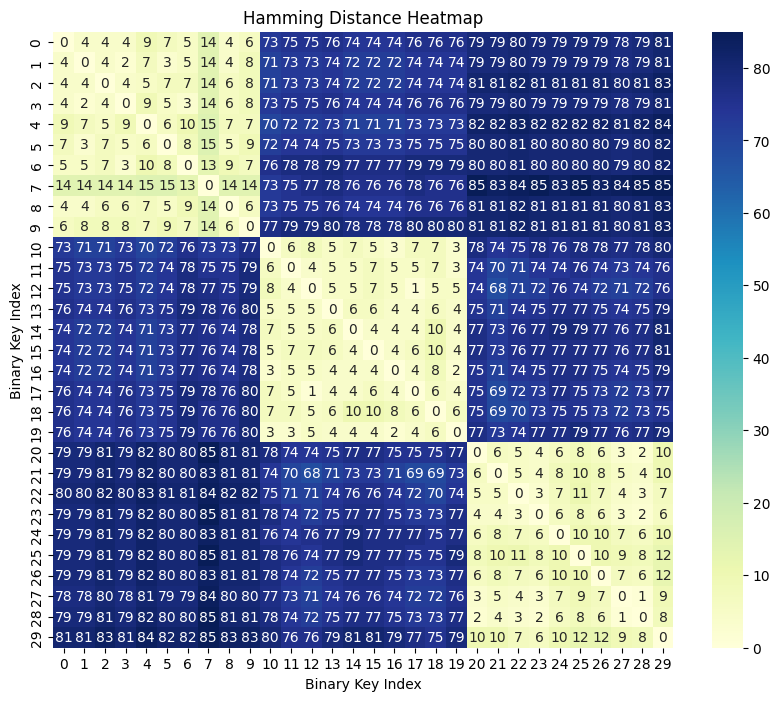

In [103]:
# Visualization of Hamming Distances
plt.figure(figsize=(10, 8))
sns.heatmap(hamming_distances, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)
plt.title('Hamming Distance Heatmap')
plt.xlabel('Binary Key Index')
plt.ylabel('Binary Key Index')
plt.show()